In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
import copy

import gymnasium as gym

from truco_env import TrucoMineiroEnv, test_game
from truco_players import LearningPlayer, RandomBotPlayer, NetworkBotPlayer, HumanPlayer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import base64
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def display_video(frames):
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=100, blit=True, repeat=False)

    gif_path = "animation.gif"
    anim.save(gif_path, writer='pillow', fps=1)

    with open(gif_path, 'rb') as f:
        gif_data = f.read()
    gif_base64 = base64.b64encode(gif_data).decode('ascii')

    return HTML(f'<img src="data:image/gif;base64,{gif_base64}">')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#test_game()

In [4]:
class TransitionBuffer:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [5]:
class PlayerBuffer:
    def __init__(self, selection_window):
        self.buffer = []
        self.selection_window = selection_window

    def register(self, player_network):
        self.buffer.append(player_network)

    def sample(self, num_players):
        return random.sample(num_players * self.buffer[-self.selection_window:], num_players)

# Deep QLearning

In [6]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self, reset_score):
        obs, info = self.env.reset(reset_score=reset_score)

        obs = np.array([*obs["current_player_cards"], obs["other_card"], obs["first_hand_winner"], obs["current_player_score"], obs["other_player_score"], obs["current_bet"], int(obs["trucable"]), int(obs["respond"]), *obs["card_frequency"]], dtype=np.int64)
        obs = torch.from_numpy(obs).unsqueeze(dim=0).float().to(device)

        return obs, info

    def step(self, action):
        obs, reward, done, info = self.env.step(action.item())

        next_state = np.array([*obs["current_player_cards"], obs["other_card"], obs["first_hand_winner"], obs["current_player_score"], obs["other_player_score"], obs["current_bet"], int(obs["trucable"]), int(obs["respond"]), *obs["card_frequency"]], dtype=np.int64)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float().to(device)
        reward = torch.tensor(reward).view(1, -1).float().to(device)
        done = torch.tensor(done).view(1, -1).to(device)

        return next_state, reward, done, info

In [7]:
class DeepQLearning:
    def __init__(self, env, eps, alpha, gamma, transition_batch_size, copy_period, change_period, selection_window, Q_network=None):
        self.env = PreprocessEnv(env)
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.transition_batch_size = transition_batch_size
        if copy_period > change_period: raise Exception("copy_period cannot be grater than change_period!")
        self.copy_period = copy_period
        self.change_period = change_period
        self.selection_window = selection_window
        self.state_dims = self._calculate_state_dims(env)
        self.num_actions = env.action_space.n
        self.num_players = env.num_players
        self._initialize_networks(Q_network)

    def _calculate_state_dims(self, env: TrucoMineiroEnv):
        state_dims = 0
        for i in env.observation_space.values():
            state_dims += 1 if type(i) == gym.spaces.Discrete else len(i)
        return state_dims

    def _initialize_networks(self, Q_network=None):
        if Q_network == None:
            self.Q_network = nn.Sequential(
                nn.Linear(self.state_dims, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, self.num_actions)
            ).to(device)
        else:
            self.Q_network = Q_network

        self.target_Q_network = copy.deepcopy(self.Q_network).eval().to(device)

    def _choose_epsgreedy_action(self, state, info):
        valid_actions = info["valid_actions"]

        if np.random.uniform(0, 1) < self.eps:
            action = np.random.choice(valid_actions)
            return torch.tensor(action).view(1, -1).to(device)
        else:
            av = self.Q_network(state).detach()
            action = valid_actions[np.argmax([av[0, valid_action].item() for valid_action in valid_actions])]
            return torch.tensor(action).view(1, -1).to(device)


    def run(self, num_episodes):
        optim = AdamW(self.Q_network.parameters(), lr=self.alpha)
        transition_buffer = TransitionBuffer()
        player_buffer = PlayerBuffer(self.selection_window)
        stats = {'MSE Loss': [], 'Returns': [], 'wins': 0, 'winrate': []}

        for episode in tqdm(range(1, num_episodes + 1)):
            state, info = self.env.reset(reset_score=True)
            done = False
            gamma_pot = 1
            ep_return = 0
            while not done:
                action = self._choose_epsgreedy_action(state, info)
                next_state, reward, done, info = self.env.step(action)

                transition_buffer.insert([state, action, reward, done, next_state])

                if transition_buffer.can_sample(self.transition_batch_size):
                    state_b, action_b, reward_b, done_b, next_state_b = transition_buffer.sample(self.transition_batch_size)
                    qsa_b = self.Q_network(state_b).gather(1, action_b)

                    next_qsa_b = self.target_Q_network(next_state_b)
                    next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]

                    target_b = reward_b + ~done_b * self.gamma * next_qsa_b
                    loss = F.mse_loss(qsa_b, target_b)
                    self.Q_network.zero_grad()
                    loss.backward()
                    optim.step()

                    stats['MSE Loss'].append(loss.item())

                ep_return += reward.item() * gamma_pot
                gamma_pot *= self.gamma
                if info["round_ended"]:
                    next_state, info = self.env.reset(reset_score=False)
                else:
                    state = next_state

            if info['victory']:
                stats['wins'] += 1
            if episode % 100 == 0:
                stats['winrate'].append(stats['wins']/episode)

            stats['Returns'].append(ep_return)

            if episode % 10 == 0:
                self.target_Q_network.load_state_dict(self.Q_network.state_dict())

            if episode % self.copy_period == 0:
                player_buffer.register(NetworkBotPlayer(f"Number {episode//self.copy_period} # Episode {episode}", copy.deepcopy(self.Q_network).eval().to(device)))

            if episode % self.change_period == 0:
                sampled_players = player_buffer.sample(self.num_players - 1)
                all_players = [LearningPlayer("deep_qlearning"), *sampled_players]
                self.env.unwrapped.set_players([all_players[0:self.num_players//2], all_players[self.num_players//2:self.num_players]])

        return stats

In [8]:
env = TrucoMineiroEnv(
    num_players=2,
    teams=[[LearningPlayer("deep_qlearning")], [RandomBotPlayer("Aleatório")]]
)

deep_qlearning = DeepQLearning(
    env = env,
    eps = 0.01,
    alpha = 0.1,
    gamma = 0.99,
    transition_batch_size = 32,
    copy_period = 100,
    change_period = 100,
    selection_window = 50,
    Q_network = None
)

stats_deep_qlearning = deep_qlearning.run(num_episodes=(num_episodes:=50000))

100%|██████████| 50000/50000 [25:53<00:00, 32.18it/s]  


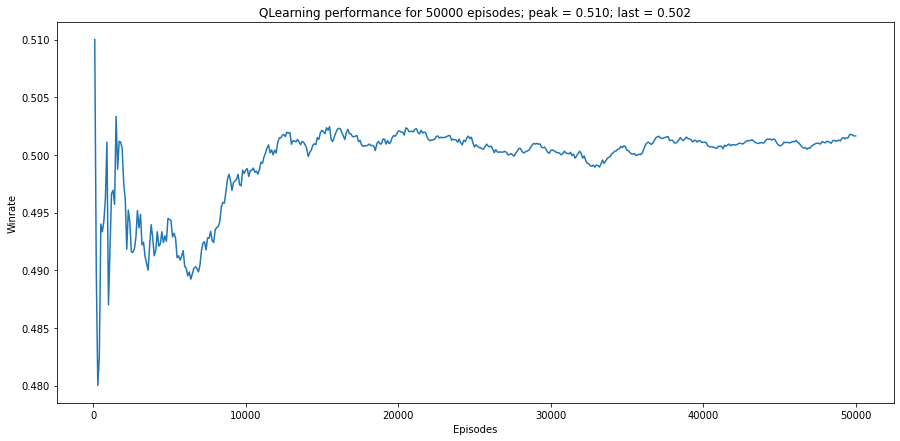

In [9]:
skip = 100
x = [i * skip for i in range(1, num_episodes//skip + 1)]
y = stats_deep_qlearning["winrate"]

plt.figure(figsize=(15, 7))
plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"QLearning performance for {num_episodes} episodes; peak = {max(y):.3f}; last = {y[-1]:.3f}")
plt.show()

## Deep SARSA

In [7]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self, reset_score=False):
        observation, info = self.env.reset(reset_score=reset_score)
        return self._get_tensor(observation), info

    def _get_tensor(self, observation):
        observation_list = []
        for _, v in observation.items():
            if isinstance(v, np.ndarray) or isinstance(v, list):
                for inner_v in v:
                    observation_list.append(inner_v)
            else:
                observation_list.append(v)

        return torch.from_numpy(np.array(observation_list)).unsqueeze(dim=0).float().to(device)

    def step(self, action):
        action = action.item()
        next_observation, reward, done, info = self.env.step(action)
        next_observation = self._get_tensor(next_observation)
        reward = torch.tensor(reward).view(1, -1).float().to(device)
        done = torch.tensor(done).view(1, -1).to(device)
        return next_observation, reward, done, info

    def render(self, render_mode="rgb_array"):
        return self.env.render(render_mode=render_mode)

In [8]:
class DeepSarsa:
    def __init__(self, env, q_network=None, alpha=0.001, transition_batch_size=32, copy_period=100,
                 change_period=100, selection_window=50, gamma=0.99, epsilon=0.05):
        self.env = PreprocessEnv(env)
        self.alpha = alpha
        self.transition_batch_size = transition_batch_size
        self.copy_period = copy_period
        self.change_period = change_period
        self.selection_window = selection_window
        self.gamma = gamma
        self.epsilon = epsilon
        self.state_dims = self._calculate_state_dims()
        self.num_actions = env.action_space.n
        self.num_players = env.num_players
        self._initialize_networks(q_network)

    def _initialize_networks(self, q_network=None):
        if not q_network:
            q_network = self._create_default_q_network()

        self.q_network = q_network
        self.target_q_network = copy.deepcopy(self.q_network).eval().to(device)

    def _create_default_q_network(self):
        default_q_network = nn.Sequential(
            nn.Linear(self.state_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_actions)
        ).to(device)

        return default_q_network

    def _calculate_state_dims(self):
        state_dims = 0

        for _, space in self.env.observation_space.spaces.items():
            state_dims += 1 if isinstance(space, gym.spaces.Discrete) else len(space.nvec)

        return state_dims

    def _choose_action(self, state, valid_actions=None):
        if valid_actions:
            valid_actions_list = [valid_actions]
        else:
            valid_actions = []
            valid_actions_list = []
            for var in state:
                respond = int(var[9]) # se tem que responder ao truco ou não
                trucable = int(var[8]) # se é possível trucar ou não
                if respond:
                    valid_actions = [4, 5]
                else:
                    for action in range(3): # cartas na mão do agente
                        if int(var[action]) != 0:
                            valid_actions.append(action)
                if trucable:
                    valid_actions.append(3)

                valid_actions_list.append(valid_actions.copy())
                valid_actions.clear()

        if torch.rand(1) < self.epsilon:
            random_actions = []
            for actions in valid_actions_list:
                # no estado terminal, retorna qlqr coisa
                if len(actions) == 0:
                    actions = [0]
                random_actions.append([int(np.random.choice(actions))])
            return torch.tensor(random_actions)

        else:
            av = self.q_network(state).detach()
            values_list = []
            for actions in valid_actions_list:
                value_list = [float("-inf")] * 6
                for i in actions:
                    value_list[i] = float(av[0][i])

                values_list.append(value_list.copy())

            valid_actions_list = torch.tensor(values_list).float()
            return torch.argmax(valid_actions_list, dim=-1, keepdim=True)

    def run(self, episodes):
        optim = AdamW(self.q_network.parameters(), lr=self.alpha)
        transition_buffer = TransitionBuffer()
        player_buffer = PlayerBuffer(self.selection_window)
        stats = {'MSE Loss': [], 'Returns': [], 'wins': 0, 'winrate': []}

        for episode in tqdm(range(1, episodes + 1)):
            state, info = self.env.reset(reset_score=True)
            done = False
            ep_return = 0
            gamma_pot = 1
            while not done:
                valid_actions = info["valid_actions"]
                action = self._choose_action(state, valid_actions)
                next_state, reward, done, info = self.env.step(action)
                transition_buffer.insert([state, action, reward, done, next_state])

                if transition_buffer.can_sample(self.transition_batch_size):
                    state_b, action_b, reward_b, done_b, next_state_b = transition_buffer.sample(self.transition_batch_size)
                    qsa_b = self.q_network(state_b).gather(1, action_b)

                    next_action_b = self._choose_action(next_state_b)
                    next_qsa_b = self.target_q_network(next_state_b).gather(1, next_action_b)

                    target_b = reward_b + ~done_b * self.gamma * next_qsa_b
                    loss = F.mse_loss(qsa_b, target_b)
                    self.q_network.zero_grad()
                    loss.backward()
                    optim.step()

                    stats['MSE Loss'].append(loss.item())

                ep_return += reward.item() * gamma_pot
                gamma_pot *= self.gamma
                if info["round_ended"]:
                    state, info = self.env.reset(reset_score=False)
                else:
                    state = next_state

            if info['victory']:
                stats['wins'] += 1
            if episode % 100 == 0:
                stats['winrate'].append(stats['wins']/episode)

            stats['Returns'].append(ep_return)

            if episode % 10 == 0:
                self.target_q_network.load_state_dict(self.q_network.state_dict())

            if episode % self.copy_period == 0:
                player_buffer.register(NetworkBotPlayer(f"Number {episode//self.copy_period} # Episode {episode}", copy.deepcopy(self.q_network).eval().to(device)))

            if episode % self.change_period == 0:
                sampled_players = player_buffer.sample(self.num_players - 1)
                all_players = [LearningPlayer("deep_sarsa"), *sampled_players]
                self.env.unwrapped.set_players([all_players[0:self.num_players//2], all_players[self.num_players//2:self.num_players]])

        return stats

    def _append_frame(self, frames, factor):
        for _ in range(factor):
            frames.append(self.env.render(render_mode="rgb_array"))
        return frames


    def test_agent(self, episodes=1, factor=1):
        if not isinstance(factor, int) or factor < 1:
            raise ValueError("Factor must be an integer greater than 0.")

        frames = []
        for _ in range(episodes):
            state, info = self.env.reset(reset_score=True)
            done = False
            frames = self._append_frame(frames, factor)

            while True:
                valid_actions = info["valid_actions"]
                action = self._choose_action(state, valid_actions)
                next_state, reward, done, info = self.env.step(action)

                if info["round_ended"]:
                    state, info = self.env.reset(reset_score=False)
                else:
                    state = next_state

                if not done:
                    frames = self._append_frame(frames, factor)
                else:
                    break

        return display_video(frames)

In [10]:
env = TrucoMineiroEnv(num_players=2, teams=[[LearningPlayer("deep_sarsa")], [RandomBotPlayer("Aleatório")]])
deep_sarsa = DeepSarsa(env = env)
stats_deep_sarsa = deep_sarsa.run(episodes=(episodes:=50000))

100%|██████████| 50000/50000 [1:42:26<00:00,  8.13it/s]  


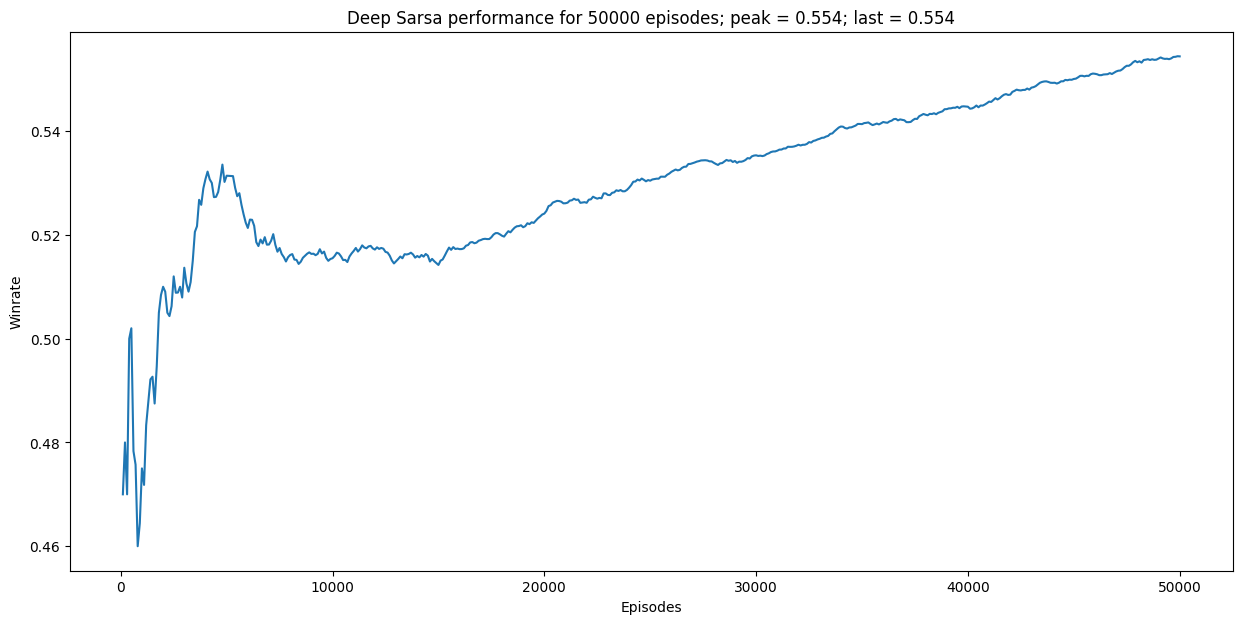

In [11]:
skip = 100
x = [i * skip for i in range(1, episodes//skip + 1)]
y = stats_deep_sarsa["winrate"]

plt.figure(figsize=(15, 7))
plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"Deep Sarsa performance for {episodes} episodes; peak = {max(y):.3f}; last = {y[-1]:.3f}")
plt.show()


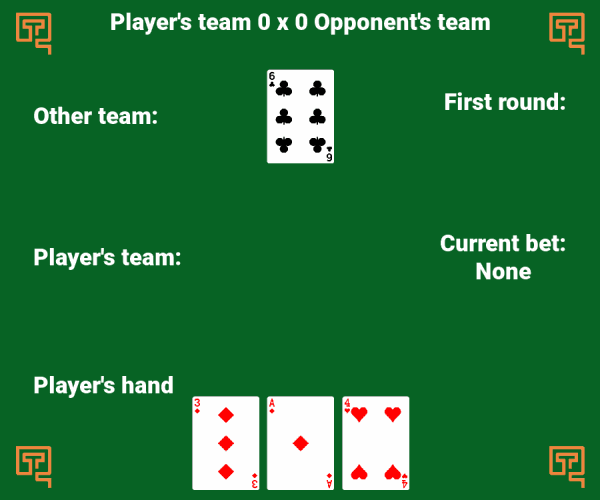

In [14]:
deep_sarsa.test_agent(episodes=1, factor=4)